# Dynamic Mode Decomposition for Trading
### Karpov Gleb, Ponomarev Evgeny, Vetsler Denis, Zankin Vitaly


In [1]:
# Импорты
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import os
from multiprocessing import Pool
import pybacktest as pb
import scipy
import numpy.linalg
import scipy.linalg
from yahoo_finance import Share
from pandas_datareader import data as pd_data
# import pandas-datareader
from pandas import Panel, DataFrame
import datetime
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()
# %load_ext ipycache

In [2]:
# Поиск аналитического решения X_DMD, такого что X_i+1 = AX_i
# X - выборка N фич на M временных слотов от 0го до M-1
# Y - выборка N фич на M временных слотов от 1го до M
# AX = Y
# r - ранг reduce SVD
def DMD(X, Y, r):
    # Найдем SVD от X
    U,s,V = np.linalg.svd(X)
    # Reduce SVD: X(NxM) = U(Nxr)S(rxr)V*(rxM)
    U = U[:,:r]
    S = np.diag(s[:r])
    V = V[:r,:]
    inv_S = np.linalg.inv(S)
    # A_bar = U*AU = U*YX^-1U = U*YVS^-1
    A_bar = (U.T).dot(Y).dot(V.T).dot(inv_S)
    # vals*vecs = A_bar*vecs - собственные векторы и значения A_bar
    vals, vecs = scipy.linalg.eig(A_bar)
    # psi = Uvecs - обратная проекция - получим с.в. и с.з. A
    Psi = U.dot(vecs)
    eigens = np.log(vals)
    # Начальные (X(0)) амплитуды
    b = np.linalg.pinv(Psi).dot(X[:,0])
    
    # Аналитическое решение
    def comp_X(t):
        t = t
        D = np.diag(np.exp(eigens*t))
        X_DMD = Psi.dot(D).dot(b)
        return X_DMD
    
    return comp_X

# Функция получения знака проиизводной
# возвращает +1 в позиции (i,j), если сfтоимость акции i выросла в момент времени j + 1
# возвращает -1 в позиции (i,j), если стоимость акции i уменьшилась в момент времени j + 1
def trend_per_time_unit(data):
    for i in range(1, data.shape[1]):
        data[:, i - 1] = (data[:, i] - data[:, i - 1]) / np.abs((data[:, i] - data[:, i - 1]))
    data = np.delete(data, data.shape[1] - 1, axis = 1) # удаляем последний столбец 
    data = np.nan_to_num(data) # заменяем nan на 0
    return data

In [3]:
# Тренировочная выборка
start = datetime.datetime(2014, 12, 1)
end = datetime.datetime(2015, 9, 1)

# Акции компаний нефтехимической отрасли с ММВБ
share_names = ['SNGSP.ME', 'LKOH.ME', 'ROSN.ME', 'GAZP.ME',\
               'NVTK.ME', 'TRNFP.ME', 'TATNP.ME', 'AKRN.ME',\
               'TATN.ME', 'URKA.ME', 'SIBN.ME', 'BANEP.ME', 'DOW']

# Использование API Yahoo! для получения исторических данных биржи
data = dict((share, pd_data.DataReader(share, "yahoo", start, end, pause=1)) for share in share_names)
panel = Panel(data).swapaxes('items', 'minor')
# Удаление NaN-ов и переход от pandas DataFrame к np.array со значениями
closing = panel['Close'].dropna()
closes = closing.values.T

In [4]:
# Возьмем из данных окно из M последних дней
# Будем смотреть на l дней вперед в аналитической функции
# Если значение аналитической ф-ии в t+l -тый день больше, чем в t-ый, то тренд растущий - нужно покупать
r = 10
M_len = 16
L_len = 10
# Запишем процент правильно принятых решений
winrates = np.zeros((len(share_names), M_len, L_len))
# Индекс Шарпа - mean(x)/std(x)
sharpes = np.zeros((len(share_names), M_len, L_len))
# Относительный прирост капитала
payoffs = np.zeros((len(share_names), M_len, L_len))
# Найдем оптимальные M и l, на которых winrate, sharpe и payoff максимальны (вместе с окресностями)
for M in range(r, r+M_len):
    for l in range(1, 1+L_len):
        # Нормируем данные
        test_data = (closes.T / np.mean(closes, axis=1) - 1).T
        trend_estimation = np.zeros(test_data.shape) 
        for t in range(M, test_data.shape[1]):
            Y = test_data[:,t-M+1:t+1]
            X = test_data[:,t-M:t]
            compute_X = DMD(X,Y,r)
            # Получи знак тренда +1 - рост, -1 - падение
            trend_estimation[:,t] = np.sign(compute_X(M+l)-compute_X(M))
        
        # Для каждой акции из shares_names запишем статистику
        for k in range(len(share_names)):
            # Обработка результатов
            # Торговая система - покупаем/продаем в зависимости от предсказанного класса
            buy = cover = pd.Series(trend_estimation[k,:] > 0, index=closing.index)
            sell = short = pd.Series(trend_estimation[k,:] < 0, index=closing.index)
            # Цены открытия, максимальные, минимальные и закрытия. Нужны для подсчета метрик бэктестером
            O = panel['Open'][share_names[k]]
            H = panel['High'][share_names[k]]
            L = panel['Low'][share_names[k]]
            C = panel['Close'][share_names[k]]
            d = {'O': O.values, 'H': H.values, 'L': L.values, 'C': C.values}
            # Запишем OHLC в pandas DataFrame
            OHLC = DataFrame(data=d, index=O.index)
            # Бэктестер получает все переменные среды
            bt = pb.Backtest(locals())
            # Формирование отчета по системе
            wr = bt.report
            winrates[k,M-r,l-1] = wr['performance']['winrate']
            sharpes[k,M-r,l-1] = wr['risk/return profile']['sharpe']
            payoffs[k,M-r,l-1] = wr['performance']['payoff']
    print(M)

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


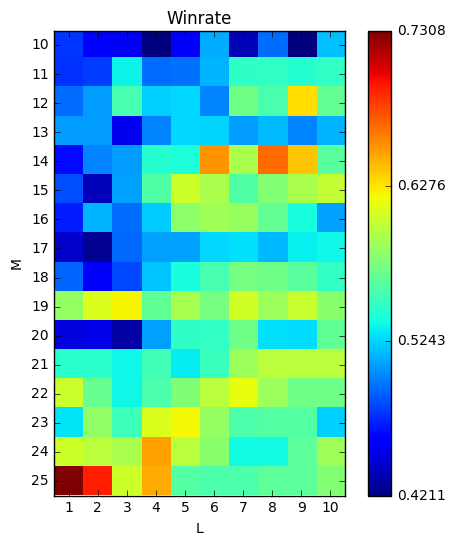

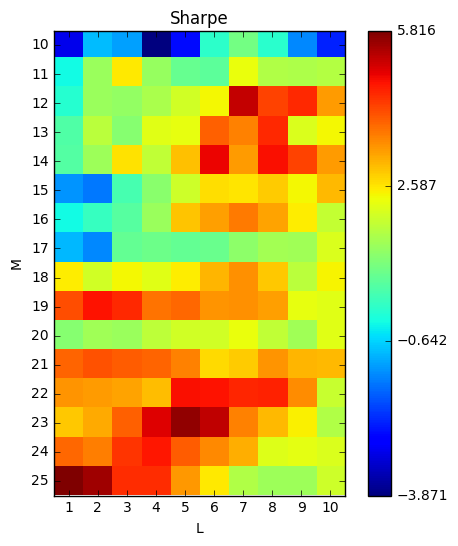

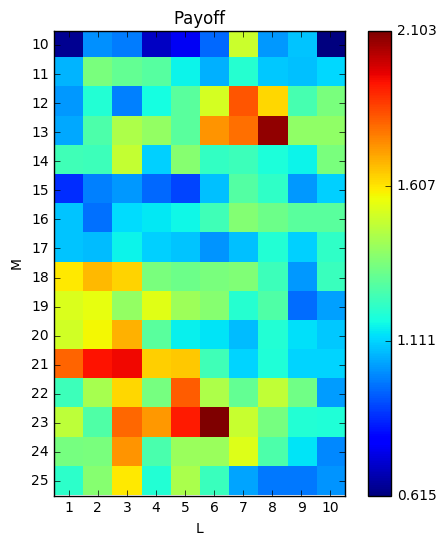

In [11]:
# Выберем акцию k для рассмотрения
k = 2
winrates_mean = winrates[k]
sharpes_mean = sharpes[k]
payoffs_mean = payoffs[k]

# График процента правильно принятых решений
# По осям y aka M-глубина окна используемых данных,
#         x aka l-по какой точке в будущем предсказывать тренд
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
img1 = ax1.imshow(winrates_mean,interpolation='nearest', cmap='jet')
v = np.linspace(winrates_mean.min(), winrates_mean.max(), 4)
cbar = plt.colorbar(img1, ax=ax1, ticks=v, orientation='vertical')
ax1.set_title('Winrate')
ax1.set_ylabel('M')
ax1.set_xlabel('L')
ax1.set_xticks(np.arange(0, L_len, 1));
ax1.set_yticks(np.arange(0, M_len, 1));
ax1.set_xticklabels(np.arange(1, 1+L_len))
ax1.set_yticklabels(range(r, r+M_len))
plt.savefig('winrates.png')
plt.show()  
plt.close()

# График коэффициента Шарпа
fig = plt.figure(figsize=(6,6))
ax2 = fig.add_subplot(111)
img2 = ax2.imshow(sharpes_mean,interpolation='nearest', cmap='jet')
v = np.linspace(sharpes_mean.min(), sharpes_mean.max(), 4)
cbar = plt.colorbar(img2, ax=ax2, ticks=v, orientation='vertical')
ax2.set_title('Sharpe')
ax2.set_ylabel('M')
ax2.set_xlabel('L')
ax2.set_xticks(np.arange(0, L_len, 1));
ax2.set_yticks(np.arange(0, M_len, 1));
ax2.set_xticklabels(np.arange(1, 1+L_len))
ax2.set_yticklabels(range(r, r+M_len))
plt.savefig('sharpe.png')
plt.show()  
plt.close()

# График относительной прибыли
fig = plt.figure(figsize=(6,6))
ax3 = fig.add_subplot(111)
img3 = ax3.imshow(payoffs_mean,interpolation='nearest', cmap='jet')
v = np.linspace(payoffs_mean.min(), payoffs_mean.max(), 4)
cbar = plt.colorbar(img3, ax=ax3, ticks=v, orientation='vertical')
ax3.set_title('Payoff')
ax3.set_ylabel('M')
ax3.set_xlabel('L')
ax3.set_xticks(np.arange(0, L_len, 1));
ax3.set_yticks(np.arange(0, M_len, 1));
ax3.set_xticklabels(np.arange(1, 1+L_len))
ax3.set_yticklabels(range(r, r+M_len))
plt.savefig('payoffs.png')
plt.show()  
plt.close()

{'risk/return profile': {'MPI': 1.6981, 'maxdd': 16.75, 'UPI': 0.4245, 'sharpe': 5.7576, 'sortino': 14.3459, 'WCDD (monte-carlo 0.99 quantile)': 33.1375}, 'backtest': {'trades': 20, 'from': '2015-10-13 00:00:00', 'to': '2016-02-29 00:00:00', 'days': 139}, 'performance': {'averages': {'trade': 3.5775, 'gain': 9.7708, 'loss': -5.7125}, 'PF': 2.5656, 'payoff': 1.7104, 'winrate': 0.6, 'profit': 71.55, 'RF': 4.2716}}


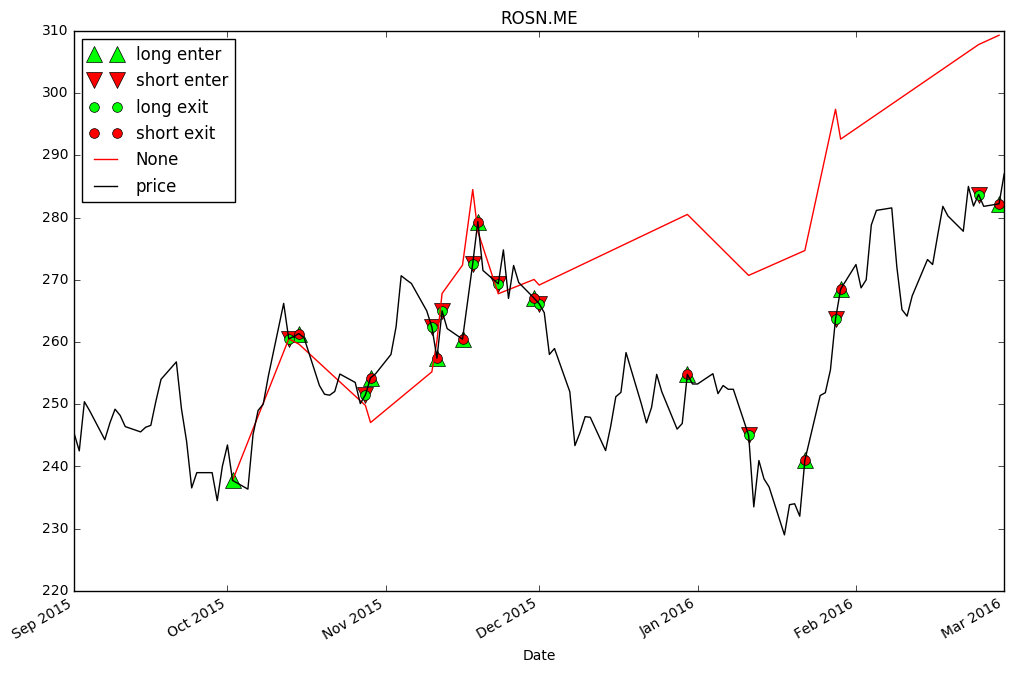

In [12]:
# Тестовая выборка
# Все то же самое, что и в тренировочной выборке, толкько с найденными ранее M и l
r = 10
M = 21
l = 3
start = datetime.datetime(2015, 9, 1)
end = datetime.datetime(2016, 3, 1)

share_names = ['SNGSP.ME', 'LKOH.ME', 'ROSN.ME', 'GAZP.ME',\
               'NVTK.ME', 'TRNFP.ME', 'TATNP.ME', 'AKRN.ME',\
               'TATN.ME', 'URKA.ME', 'SIBN.ME', 'BANEP.ME', 'DOW']

data = dict((share, pd_data.DataReader(share, "yahoo", start, end, pause=1)) for share in share_names)
panel = Panel(data).swapaxes('items', 'minor')
closing = panel['Close'].dropna()
closes = closing.values.T

test_data = (closes.T / np.mean(closes, axis=1) - 1).T
trend_estimation = np.zeros(test_data.shape) 
for t in range(M, test_data.shape[1]):
    Y = test_data[:,t-M+1:t+1]
    X = test_data[:,t-M:t]
    compute_X = DMD(X,Y,r)
    trend_estimation[:,t] = np.sign(compute_X(M+l)-compute_X(M))

buy = cover = pd.Series(trend_estimation[k,:] > 0, index=closing.index)
sell = short = pd.Series(trend_estimation[k,:] < 0, index=closing.index)
O = panel['Open'][share_names[k]]
H = panel['High'][share_names[k]]
L = panel['Low'][share_names[k]]
C = panel['Close'][share_names[k]]
d = {'O': O.values, 'H': H.values, 'L': L.values, 'C': C.values}
OHLC = DataFrame(data=d, index=O.index)
bt = pb.Backtest(locals())

# Отчет по системе
print(bt.report)
# Основной график эквити
fig = plt.figure(figsize=(12, 8))
bt.plot_trades()
plt.legend(loc = 'best')
plt.title(share_names[k])
plt.show()